In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from UTILS import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

# OS Parameters
model_folder = 'models/'
log_folder = 'logs/'
data_folder = 'data/datasets'
tsne = TSNE()


Using TensorFlow backend.


# SEISMOGRAM SIMILARITY

---


This tutorial presents a novel measure of seismogram similarity that is explicitly invariant to path. The work is based on the paper "Beyond Correlation: A Path-Invariant Measure for Seismogram Similarity" by Joshua Dickey, Brett Borghetti, William Junek and Richard Martin, which can be viewed in full on the ArXiv: https://arxiv.org/pdf/1904.07936.pdf.

The tutorial consists of 5 parts:

1) Background

2) Data Exploration

3) Similarity Model

4) Pairwise Association

5) Template-based Discrimination

---
### BACKGROUND

#### Path-Dominant Similarity:

Similarity search is a popular technique for seismic signal processing, including both signal detection and source discrimination. Traditionally, these techniques rely on the cross-correlation function as the basis for measuring similarity. Unfortunately, seismogram correlation is dominated by path effects, as shown in the figure below:

<img src="images/Path_dominant_similarity.png" width="400px">


The figure shows three Seismograms, each depicting an explosion at a coal mine near Thunder Basin, WY. Seismograms a) and b) depict a common source event (600221452), recorded at two separate seismic stations, ISCO and K22A respectively. Seismogram c) depicts a nearby event (600221802), also recorded at K22A. The correlation and visual similarity between the path-similar waveforms b) and c) is obvious. This path-dominant similarity can be desirable when detecting aftershock sequences from a particular fault, or mining blasts from within a small quarry. For general detection and discrimination, however, path-dominant similarity is problematic, as path differences of even just a quarter wavelength can significantly degrade the correlation of two seismograms.




#### Path-Invariant Similarity:

We now envision a new measure of seismogram similarity, that is path-independant. The notional diagram below illustrates an embedding function, $f(\cdot)$, which is a non-linear transformation that maps time-series seismograms to low-dimensional embeddings. The mappings are desired to be path-invariant and source-specific, such that regardless of the recording station, all seismograms associated with a particular event are mapped closely in the embedding space, and seismograms not associated with that event have more distant embeddings. We propose to learn such an embedding function explicitly, using a specialized convolutional neural network architecture, called a triplet network.

<img src="images/STA_dominant_similarity.png" width="400px">

The Triplet Network is trained on batches of $m$ triples, where each triple is comprised of an anchor object, $X_A^{(i)}$, a positive object, $X_P^{(i)}$, and a negative object, $X_N^{(i)}$. The triplet loss function computes the relative embedding distance between the matched pair and non-matched pair, and loss is accrued whenever the matched pair distance is not smaller than the non-matched distance by some margin, $\alpha$, as given in the Equation below:

$\mathcal{J} =  \sum^{m}_{i=1} [ \langle f(X_A^{(i)}) , f(X_P^{(i)}) \rangle - \langle f(X_A^{(i)}) , f(X_N^{(i)}) \rangle + \alpha ] \small_+ $ 

To learn path-invariant embeddings, we simply pick our triples such that the anchor and positive objects are seismograms sharing the same source event, but recorded at different stations. In this way, the network learns a transformation that is invariant to path, calibration function, recording equipment and station.

---
### DATA EXPLORATION

#### EarthScope Observatories:
Learning a path-invariant measure for seismogram similarity requires a training dataset with many recordings of a single seismic event across many disparate paths. This is best accomplished by a dense network of seismometers across a wide region. EarthScope's USArray dataset is ideally suited for this endeavor. In particular, we utilize two EarthScope observatories, the Transportable Array and the Reference Array, as the basis for our Training and Test Sets, respectively. The Training set includes all catalogged waveforms from 2007 to 2013. The validation set includes all catalogged waveforms from 2014. The Test set includes all cataloged waveforms from 2015 and 2016.

In [2]:
cat_trn = read_cat(os.path.join(data_folder, "Y_USArray_07-13_conus_holdout.csv"))
cat_val = read_cat(os.path.join(data_folder, "Y_USArray_14_conus.csv"))
cat_tst = read_cat(os.path.join(data_folder, "Y_USArray_15-16_conus.csv"))
cat_tot = pd.concat([cat_tst, cat_val, cat_trn])


#### Hold-out Test Set:
All of the events in the test set are mutually exclusive with the training and validation data. Additionally, several stations and locations were held out during testing, including 51 novel stations, and 87 events from a novel location near the Rosebud mine in Montana. Performance is evaluated explicitly on these novel data to explore the power and generalization of the technique. 

In [3]:
# Identify all novel stations unique to the test set
cat_tst['novel_sta'] = 0
cat_tst.loc[~ cat_tst.STA.isin(cat_trn.STA.unique()), 'novel_sta'] = 1

# Identify all events from the Rosebud mine (held out during training)
cat_tst['novel_evt'] = 0
cat_tst.loc[(cat_tst.LAT_1>45) & (cat_tst.LAT_1<47) & 
            (cat_tst.LON_1>-108) & (cat_tst.LON_1<-106), 'novel_evt'] = 1

# Identify all novel Rosebud events recorded by novel stations
cat_tst['novel_all'] = 0
cat_tst.loc[(cat_tst.novel_evt==1)&(cat_tst.novel_sta==1),'novel_all'] = 1

cat = cat_tst


#### Regional Network:
All three datasets, training, validation and test, were limited to events with near CONUS epicenters, as defined by the following limits on latitude and longitude: 25 $<$ LAT $<$ 50, and -125 $<$ LON $<$ -75. This accomplishes two purposes. First, this produces a catalog with more balanced samples of explosions and earthquakes, 207,291 and 26,568 respectively. Second, this restricts the study to regional signals. Regional signals are preferred due to the more manageable window length requirements vs teleseismic signals, as well as because the regional association task is much more interesting than the teleseismic association task; teleseismic signals recorded by such a dense regional network look much more similar even using traditional seismic similarity.

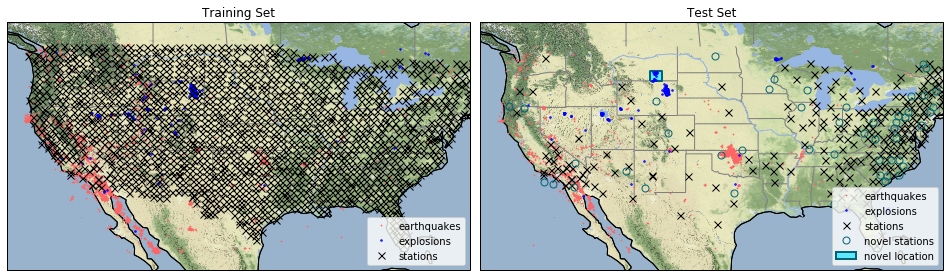

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(13,10), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
xt = [-126.9784, -73.0766, 23.0038, 51.7985]

plot_cat_map(cat_trn, 'Training Set', True, ax=ax[0], extents=xt)
plot_cat_map(cat_tst, 'Test Set', True, True, ax=ax[1], extents=xt)

fig.canvas.draw()
fig.tight_layout(pad=0, w_pad=1, h_pad=0)


#### Magnitude and Distance Histograms:
We also have included histograms of seismogram station-to-event distances as well as event magnitudes for both the test and training sets, shown in the figures below:

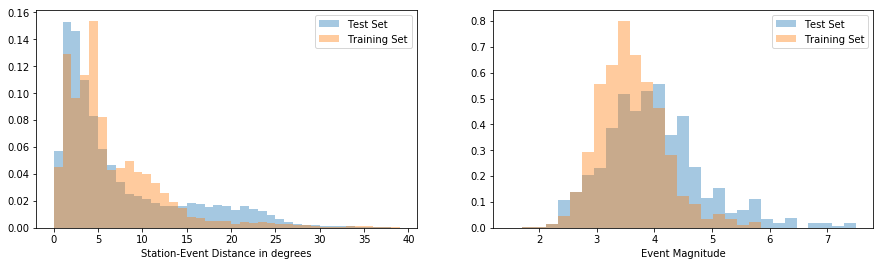

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
z = zip([0,1], ['DIST', 'MAG'], [list(range(40)), np.linspace(1.5,7.5,30)], 
        ['Station-Event Distance in degrees', 'Event Magnitude'])
    
for i, feat, bins, xlabel in z:
    sns.distplot(cat_trn[[feat]], bins=bins, ax=ax[i], kde=False, 
                 label='Test Set', norm_hist=True)
    sns.distplot(cat_tst[[feat]], bins=bins, ax=ax[i], kde=False, 
                 label='Training Set',norm_hist=True)
    ax[i].legend()
    ax[i].set_xlabel(xlabel)
    

---
### SIMILARITY MODEL
The goal is to learn a path-invariant embedding function for seismograms, useful for source discrimination at up to regional distances. This is accomplished using a hybrid architecture with two distinct parts: First, a TCN is employed with a receptive field wide enough to capture both P and S wave phases; second, a densely connected output layer, with 32 nodes, is employed to facilitate a rich low-dimensional embedding space. 

The TCN is designed to have an overall receptive field of 4171 samples (104 seconds), allowing it to learn long-period features down to 0.01 Hz, with just four dilated convolutional layers, as shown in the Table below:

<img src="images/TCN_parameters.png" width="200px">

The TCN architecture consists of two residual stacks, each with 50 filters and a kernel size (filter length) of 16 samples. Finally, the TCN output is encoded by a densely connected output layer with 32 nodes, and the final output vector is normalized to have unit length. This results in 553,835 trainable parameters, and a network which reduces the three-channel 21,600 dimensional input into just 32 dimensions, for a 99.9\% reduction in dimensionality.

<img src="images/TCN_stack_sim.png" width="400px">



#### Embedding Space Transformation:

The seis-sim repository (https://github.com/joshuadickey/seis-sim) includes all the code necessary to train and test a similarity model from scratch, including the code to transform the dataset onto the embedding space. However, this requires a significant amount of data be downloaded from the ISC. This download process can take several days, even with a fast internet connection. As such, and for convienience, we have also provided a set of pre-transformed embeddings for the test set. To use the pre-transformed embeddings, __use_provided_emb__ should be set to True. Otherwise, if you have downloaded the data and wish to transform the waveforms yourself, __use_provided_emb__ should be set to False.

In [6]:
dat, emb = get_emb(dataset_name = 'USArray_15-16_conus', 
                   model_id = '19-07-27-09-34-30', 
                   use_provided_emb = True)


loading previous model:
 models/f:50|k:15|d:1x2x4x8|s:2|n:1|od:32|trn:USArray_07-13_conus_holdout|val:USArray_14_conus|dtrd:1|norm:1|pre:30|post:150|sh:0.05|numP:7|numK:7|m:0.5|a:0.001|lr:0.005|pat:7|iniW:19-07-27-06-49-34|time:19-07-27-09-34-30.h5

loading embeddings... generating placeholder waveforms... complete


---
### PARIWISE ASSOCIATION

Event association is the process of correctly associating the arriving seismic phases of a single event across a network, and is a critical step in seismic analysis. The traditional algorithms used for this task have always been based on travel times and earth velocity models, however our method is similarity-based: we associate the seismograms entirely based on their pairwise similarity in the embedding space, with no external information about arrival times or recording locations. This is a binary classification task: given a pair of seismograms, $X_A$ and $X_B$, the algorithm must classify the pair as matched or unmatched, where a matched pair is defined as two seismogram recordings of the same event. Classification is accomplished by comparing the similarity-based test statistic, $S$, against a user defined threshold, $\tau$, as seen in the equation below:



$H_0$: UNMATCHED ($X_A$ and $X_B$ depict distinct events)

$H_A$: MATCHED ($X_A$ and $X_B$ depict a common event)

$S = \frac{1}{\langle f(X_A) , f(X_B) \rangle}$


reject $H_0$ if S $\geq \tau$


#### 2D Visualized Embeddings for Association:
Six unique seismic events were randomly selected from the dataset, along with 20 seismograms for each event, recorded at various stations. These 120 seismograms were then mapped to the 32-dimensional embedding space via the trained neural network. Finally, the 32-dimensional embedding space was visualized here in two dimensions using t-SNE, with each unique event assigned a unique marker. The clustering of same-event embeddings is the result of shared feature commonalities between seismograms of that event.

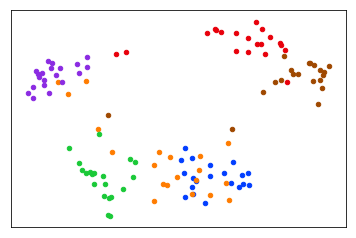

In [7]:
gen = generator_hard(dat, cat, n_P=6, n_K=20, return_cat=True)
my_cat, my_y = next(gen)

my_emb = np.take(emb, my_cat.index, axis=0)
my_tsne = tsne.fit_transform(my_emb)

scatter(my_tsne, my_y, annotate=False)


#### Embedding Distance Histograms:
Histograms of matched and unmatched pair distances for the test set. The matched-pair distribution includes embedding space distances for 25,000 pairs of seismograms, where the two embeddings come from the same event. The unmatched-pair distribution includes embedding space distances for 25,000 pairs of seismograms, where the two embeddings come from different events. A cutoff threshold of 0.24 was used to obtain maximum classification accuracy, and is annotated by the dashed line. For this threshold, the area of overlap between the two density plots represents the total classification error, which is  $\sim$20\%.

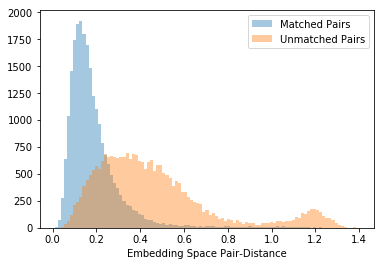

In [8]:
samps = 25000
sns.distplot(get_random_pos_pairs(emb, cat, 'EVENTID', samps), 
             bins=np.linspace(.01,1.4,100), kde=False, label='Matched Pairs')
sns.distplot(get_random_neg_pairs(emb, cat, 'EVENTID', samps), 
             bins=np.linspace(.01,1.4,100), kde=False, label='Unmatched Pairs')
plt.legend()
_ = plt.xlabel('Embedding Space Pair-Distance')


#### Construct ROC curves for Association:

Receiver Operating Characteristic Curve for the Event Association task. The overall area under the curve is 86.8\%.

total pairs:          50000
type-I error rate:    0.20808
-------------
accuracy:             79.6%
recall:               79.9%
precision:            79.3%
-------------
TP    19978
TN    19798
FP     5202
FN     5022
Name: COND, dtype: int64


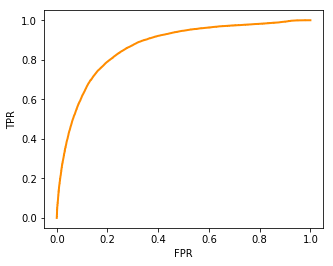

In [9]:
assoc_cat, _ = assoc_test_gen(cat, emb, 50000)

fig, ax = plt.subplots(figsize=(5,4))
fpr, tpr, th = roc_curve(assoc_cat.Y.values, assoc_cat.Y_score.values)
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, color='darkorange', lw=2, label='Proposed Associator')
_ = ax.set_xlabel('FPR')
_ = ax.set_ylabel('TPR')


#### Residuals By Distance:
As noted previously, correlation-based seismogram similarity is known to decay exponentially with an increase in the distance between recording stations. Our path-invariant measure is also negatively affected by increasing this distance, but the decay is only linear. This is clearly demonstrated in the Table below:

In [10]:
residual_by_dist(assoc_cat)


  Distance	  P	  R	 Acc
0000-0250 km	0.834	0.877	0.851
0250-0500 km	0.814	0.763	0.794
0500-0750 km	0.842	0.746	0.803
0750-1000 km	0.793	0.766	0.783
1000-1250 km	0.783	0.846	0.806
1250-1500 km	0.762	0.831	0.786
1500-1750 km	0.708	0.874	0.757
1750-2000 km	0.735	0.840	0.769
2000-2250 km	0.717	0.817	0.747


#### Residuals By Novel Station and Event:
The ability of the embedding space to associate regional events across hundreds of stations with 80\% accuracy based entirely on waveform similarity is surprising, and begs the question: is the neural network really extracting generalized path-invariant features, or is it merely _memorizing_ all the training paths exactly, in a way
that appears to support conclusions that are unwarranted. To answer this question, we investigate the ability of the embedding space to associate waveforms from novel stations and locations as detailed in the Tables below. Here, we find that although the performance does drop for such events, the drop is relatively minor. For instance, the accuracy drop is negligible when considering novel stations, which demonstrates that the neural network has indeed learned to extract features that are invariant to recording location, even novel ones. The accuracy drop is slightly more significant when considering novel event locations, decreasing from 80\% to 75\% for pairs where at least one event originated near the held-out Rosebud mine. This is understandable, as withholding training events from a certain source location obviously impairs the ability of the neural network to extract features unique to such events at test time.

In [11]:
residual_cols = ['novel_sta', 'novel_evt', 'novel_all', 'DIST']

residual_cat = association_residualizer(assoc_cat, cat, residual_cols)
display(residual_by_feat(residual_cat, 'novel_sta'))
display(residual_by_feat(residual_cat, 'novel_evt'))
display(residual_by_feat(residual_cat, 'novel_all'))


novel_sta


,TOT,ERR,ACC
0,32238,6404,0.80
1,17762,3820,0.78


novel_evt


,TOT,ERR,ACC
0,49805,10171,0.80
1,195,53,0.73


novel_all


,TOT,ERR,ACC
0,49893,10185,0.80
1,107,39,0.64


---
### TEMPLATE-BASED DISCRIMINATION:

The source discrimination task is formulated as binary classification, where unlabeled seismograms $X$ are classified as either explosion or earthquake, based on their embedding space similarities to both the centroid of a set of explosion templates, $X_{EXP}$ and the centroid of a set of earthquake templates, $X_{EQK}$. This is shown in the equation below, where $\epsilon$ is machine precision:

$H_0$: EARTHQUAKE ($X$ depicts an earthquake)

$H_A$: EXPLOSION ($X$ depicts an explosion)

$S = \frac{\langle f(X) , f(X_{EQK}) \rangle}{\langle f(X) , f(X_{EXP}) \rangle + \epsilon}$

reject $H_0$ if $S \geq \tau$

#### 2D Visualized Embeddings for Discrimination:

Two-thousand embeddings are shown, visualized in 2D using t-SNE, and labeled according to source function. The light-colored dots represent explosions and the darker dots represent earthquakes; the cluster centroids are annotated by 1 and 0, respectively. The 2D clustering of embeddings demonstrates the inherent association between embeddings with a common source function.

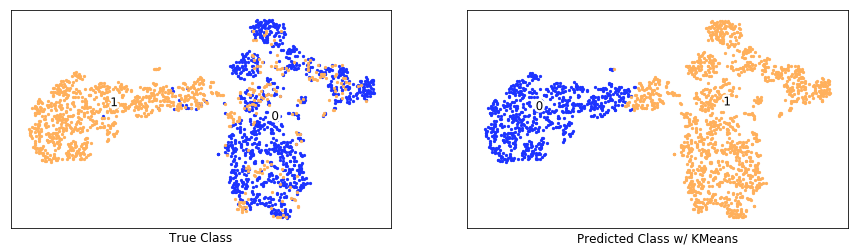

In [12]:
bs = 1000
fig, ax = plt.subplots(1, 2, figsize=(15,4))

# Select 2,000 embeddings and plot using tsne
my_cat = pd.concat([cat.loc[cat.Y == 1].sample(bs), 
                    cat.loc[cat.Y == 0].sample(bs)])
my_emb = np.take(emb, my_cat.index, axis=0)
my_tsne = tsne.fit_transform(my_emb)

# Points are colored based on their true class (explosion vs earthquake)
scatter(my_tsne, my_cat.Y.values, ax=ax[0], annotate=True, mk_sz=5, 
        mk_c=['#1c33ff', '#ffb05c'], subtitle='True Class')

# Points are colored based on a simple 2-mean cluster
scatter(my_tsne, KMeans(n_clusters=2).fit_predict(my_emb), ax=ax[1], annotate=True, 
        mk_sz=5, mk_c=['#1c33ff', '#ffb05c'], subtitle='Predicted Class w/ KMeans')


#### Construct ROC curves for Discrimination:

Receiver Operating Characteristic Curves for the Source Discrimination task identifying all explosions. Three plots are shown, demonstrating performance across various numbers of templates (1, 3 and 10). Because the template are chosen randomly, we have performed 1,000 trials for each plot, with the results of each trial plotted as a separate curve. Performance converges nicely for only 3 templates.

total pairs:          35694
type-I error rate:    0.022196510671984897
-------------
accuracy:             95.8%
recall:               73.3%
precision:            74.1%
-------------
TN    32114
TP     2091
FN      760
FP      729
Name: COND, dtype: int64


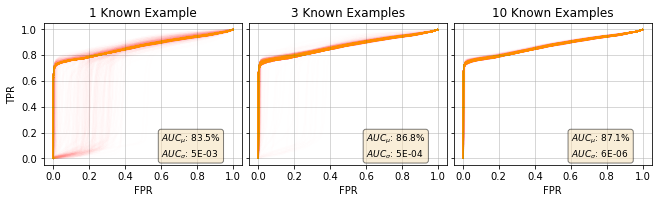

In [13]:
feat = 'Y'
oneshotPlot(cat, feat, emb, samps_list=[1, 3, 10], 
            trials=1000, title=f'oneshot_ROCs.png')
cat, stats = classPerf(cat, feat, emb, samps=3)


#### Confusion Matrix for Discrimination:

The confusion matrix demonstrates performance against the test set.

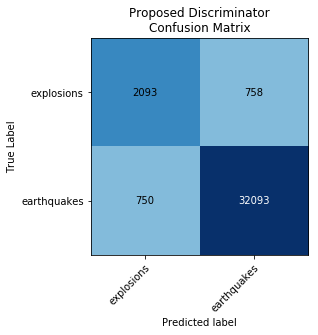

In [14]:
plot_confusion(cm=stats[3], 
               class_names=['explosions', 'earthquakes'], 
               title='Proposed Discriminator\nConfusion Matrix')


#### Discrimination Residuals for the Novel Event Region:

Finally, we examine the discrimination performance for all events from the rosebud mine. Events from this region were held out during training. As you can see, the recall for these events is quite similar to the overall population.

In [15]:
r = cat.loc[(cat.novel_evt == 1) & (cat.Y == 1), 'Y_pred'].mean()
print(f'Rosebud Recall: {100*r:0.01f}%')


Rosebud Recall: 72.4%
